In [ ]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [ ]:
df = pd.read_excel("RUT RV.xlsx",index_col='Date',parse_dates=True)

In [ ]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'RV':'y'}, inplace=True)
df.drop(columns=["wasserstein_dists_2D"], inplace=True)
df["unique_id"]="airplane1"
train = df.iloc[:int(len(df['y'])*0.8)]
test = df.iloc[int(len(df['y'])*0.8):]
validation_length=int(len(df['y'])*0.8)-int(len(df['y'])*0.6)

In [ ]:
n_inputs = [5,10,21,63,84,126,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs=[25,50,100,150,250,350,450,550,750]
learning_rate=[0.0005,0.0001,0.00005,0.00001]
num_lr_decays=[5,3,2,1]
dropouts=[0,0.2,0.3,0.4,0.5]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_blocks=[[1, 1],[2, 2],[3, 3],[5, 5]]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[90]),MQLoss(level=[80, 90]),MQLoss(level=[95]), MQLoss(level=[75])]


# Hyperparameter Search

In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 80640707


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 69352391


Epoch: 750 | Inputs: 84 | MLP units: [[712, 712], [712, 712]] | Loss: 0 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.0035836532593555726 | QLIKE: 0.10931019370339269


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 5763250


Epoch: 25 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: 2 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.003780775813188541 | QLIKE: 0.12449638197022159


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 111353785


Epoch: 750 | Inputs: 84 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.0031542419358481324 | QLIKE: 0.08320920646017031


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 60014341


Epoch: 150 | Inputs: 5 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.003718033228914638 | QLIKE: 0.10510916926610316


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 100 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.0037999178894320544 | QLIKE: 0.12626280735683


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 866960


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 3840920


Epoch: 750 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [3, 3]
RMSE: 0.003264961857646155 | QLIKE: 0.08789105364102841


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 113055027


Epoch: 750 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.0033136204870938776 | QLIKE: 0.09297407342613082


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 53207866


Epoch: 25 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.0038348933127604298 | QLIKE: 0.13072188805756216


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 7689793


Epoch: 100 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.0036764543191751815 | QLIKE: 0.1140179238550756


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 25 | Inputs: 252 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.0038542438359421716 | QLIKE: 0.13961015636290255


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 112403720


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 86329656


Epoch: 50 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.003644474931081987 | QLIKE: 0.15190282892995216


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 117565293


Epoch: 550 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.0037754998937064004 | QLIKE: 0.12397093331840604


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 118475125


Epoch: 150 | Inputs: 5 | MLP units: [[250, 250], [250, 250]] | Loss: 1 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.0032260366934390165 | QLIKE: 0.0883919058351651


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 118492718


Epoch: 100 | Inputs: 21 | MLP units: [[712, 712], [712, 712]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.0032478180466115076 | QLIKE: 0.09365426380534957


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 550 | Inputs: 84 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [3, 3]
RMSE: 0.0033826234574889816 | QLIKE: 0.09368287353992963


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 35403332


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 13841802


Epoch: 100 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: 1 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.0038812231890925325 | QLIKE: 0.13098282691766014


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 14406153


Epoch: 550 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: 5 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.0031896205450116055 | QLIKE: 0.08486593508864852


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 54153662


Epoch: 100 | Inputs: 252 | MLP units: [[712, 712], [712, 712]] | Loss: 3 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.0038438256249829724 | QLIKE: 0.13376452895271335


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 31575538


Epoch: 25 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.003943636918261586 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 350 | Inputs: 84 | MLP units: [[712, 712], [712, 712]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.0031359096230693336 | QLIKE: 0.08043163865083988


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 64185194


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 22782732


Epoch: 25 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: 3 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.003977177744864641 | QLIKE: 0.16195827763747317


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 94353207


Epoch: 750 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.0030467759505238942 | QLIKE: 0.07661298325029604


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 93902686


Epoch: 450 | Inputs: 10 | MLP units: [[250, 250], [250, 250]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.0032136850015782523 | QLIKE: 0.08968890508082801


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 3012203


Epoch: 550 | Inputs: 252 | MLP units: [[512, 512], [512, 512]] | Loss: 0 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.0033993106648255284 | QLIKE: 0.10421542865490924


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 450 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.0032168685854260482 | QLIKE: 0.0859063207797131


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 96141899


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 120332303


Epoch: 350 | Inputs: 10 | MLP units: [[100, 100], [100, 100]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.003784784347753224 | QLIKE: 0.13862799224210556


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80643154


Epoch: 100 | Inputs: 84 | MLP units: [[100, 100], [100, 100]] | Loss: 4 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.003466618668285301 | QLIKE: 0.11369382824391003


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 47837354


Epoch: 50 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: 2 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.0037474405094491056 | QLIKE: 0.13167224185071735


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 31053586


Epoch: 50 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.003216033773306512 | QLIKE: 0.08793342641577934


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 550 | Inputs: 10 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.0032348493002559023 | QLIKE: 0.08292194890587057


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 79919676


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 124860083


Epoch: 550 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: 4 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [1, 1]
RMSE: 0.003404499937420489 | QLIKE: 0.11245843580032108


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 57546496


Epoch: 250 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.0036269223115034687 | QLIKE: 0.11507072738595127


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 54482411


Epoch: 150 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.003821743460441549 | QLIKE: 0.1309746821810024


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 65960959


Epoch: 750 | Inputs: 5 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.00323116333870667 | QLIKE: 0.08755096106674415


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 350 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.0035059335938390683 | QLIKE: 0.10983896228210345


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 11023505


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 121185326


Epoch: 750 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [3, 3]
RMSE: 0.0032108879991135956 | QLIKE: 0.08755979416687178


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 55948569


Epoch: 100 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.0031880499297185444 | QLIKE: 0.08251843255820906


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 102805890


Epoch: 450 | Inputs: 5 | MLP units: [[712, 712], [712, 712]] | Loss: 1 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [1, 1]
RMSE: 0.003183759269542437 | QLIKE: 0.08906836575887


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 83951797


Epoch: 250 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: 4 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.0031284813927915226 | QLIKE: 0.07988535626161869


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 100 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.003878512318024449 | QLIKE: 0.14144054612152743


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 20234912


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 95707356


Epoch: 50 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.003670695580826699 | QLIKE: 0.11835358535374141


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 113978084


Epoch: 100 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.003773524913147484 | QLIKE: 0.13482297002651508


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 9562766


Epoch: 750 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.0031412053498258903 | QLIKE: 0.08207654155345624


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 62250901


Epoch: 50 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.0031827971174638835 | QLIKE: 0.08856489040082363


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 750 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.0032683555271618035 | QLIKE: 0.09027914742717705


Epoch: 750 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.0030467759505238942 | QLIKE: 0.07661298325029604


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[1],
                scaler_type='minmax',
                learning_rate= 0.00001,
                stack_types=['trend','identity'],
                n_blocks=[2,2],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=1,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=750,
                early_stop_patience_steps=1,
                random_seed=random_seed)
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 50402126


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 89880245


Seed: 50402126
RMSE: 0.003074773654295266 | QLIKE: 0.07684451372671255


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 37367624


Seed: 89880245
RMSE: 0.003080196629368436 | QLIKE: 0.07741229191630396


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80666292


Seed: 37367624
RMSE: 0.0030575386104249643 | QLIKE: 0.07672798228660509


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 54097407


Seed: 80666292
RMSE: 0.0031128390713899773 | QLIKE: 0.08304705649436962


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 54097407
RMSE: 0.0031850486896457717 | QLIKE: 0.08584460816483931


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[1],
                scaler_type='minmax',
                learning_rate= 0.00001,
                stack_types=['trend','identity'],
                n_blocks=[2,2],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=1,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=750,
                early_stop_patience_steps=1,
                random_seed=random_seed)
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 118474753


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 116297177


Seed: 118474753
RMSE: 0.00337164887971568 | QLIKE: 0.09695085959032072


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 25375246


Seed: 116297177
RMSE: 0.0031323004397857666 | QLIKE: 0.08467768392364883


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 129109241


Seed: 25375246
RMSE: 0.0033702700963812436 | QLIKE: 0.10233039927578733


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 83146059


Seed: 129109241
RMSE: 0.00308242965781896 | QLIKE: 0.07948976901172516


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 83146059
RMSE: 0.0030872032848211837 | QLIKE: 0.07885263316449323


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[1],
                scaler_type='minmax',
                learning_rate= 0.00001,
                stack_types=['trend','identity'],
                n_blocks=[2,2],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=1,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=750,
                early_stop_patience_steps=1,
                random_seed=random_seed)
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 77868988


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 127834737


Seed: 77868988
RMSE: 0.0031839894814665298 | QLIKE: 0.08608287730823354


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 77568521


Seed: 127834737
RMSE: 0.0030470727908752434 | QLIKE: 0.07737351028769475


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Seed: 77568521
RMSE: 0.00309044422302365 | QLIKE: 0.07947936977180468


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 68361232


Seed: 89361800
RMSE: 0.0030973573223599584 | QLIKE: 0.08050156635688639


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 68361232
RMSE: 0.003230613673520741 | QLIKE: 0.08979384861026142


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[1],
                scaler_type='minmax',
                learning_rate= 0.00001,
                stack_types=['trend','identity'],
                n_blocks=[2,2],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=1,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=750,
                early_stop_patience_steps=1,
                random_seed=random_seed)
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 56829448


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 119442577


Seed: 27348877
RMSE: 0.0031257265619135197 | QLIKE: 0.08160735778763924


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80556118


Seed: 119442577
RMSE: 0.003079490308723374 | QLIKE: 0.0782889487411895


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 61490621


Seed: 80556118
RMSE: 0.003137208034701657 | QLIKE: 0.0805992085511248


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 61490621
RMSE: 0.0030994113159743754 | QLIKE: 0.08004878794151897


# H=5 Forecasts

In [ ]:
RMSE=[]
Quasilikelihood=[]

In [ ]:
test_length=len(df["y"])-int(len(df['y'])*0.8)

In [ ]:
model = NBEATSx(h=5, input_size=63,
              loss=losses[1],
              scaler_type='minmax',
              learning_rate= 0.00001,
              stack_types=['trend','identity'],
              n_blocks=[2,2],
              mlp_units= [[712, 712], [712, 712]],
              windows_batch_size=60,
              num_lr_decays=1,
              val_check_steps=100,
              n_harmonics=1, n_polynomials=0,
              hist_exog_list=['VIX'],
              max_steps=750,
              early_stop_patience_steps=1,
              random_seed=22782732)
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%5,step_size=5)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true)))
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 22782732


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
print(f"RMSE: {round(np.mean(RMSE)*100,4)}%")
print(f"QLIKE: {round(np.mean(Quasilikelihood)*100,2)}%")

RMSE: 0.49%
QLIKE: 10.0%


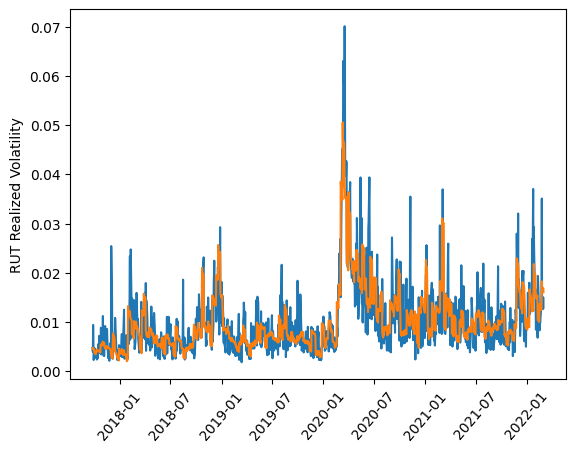

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("RUT Realized Volatility")
plt.xticks(rotation=50)
plt.show()

In [ ]:
Data = {'Date': forecasts["ds"],
        'Actuals': Y_true,
        'Forecast without PH': Y_hat
        }
df1=pd.DataFrame(data=Data)
df1.to_csv("Forecast without PH (NBEATSx).csv")